# Frequency Analysis - Single Subject Report

Ref: https://github.com/mne-tools/mne-tools.github.io/blob/59d49be2769d80f25ba26c78caadd0ba4941345d/stable/_downloads/58e35821e0f211b843d5ead3e33d8849/20_sensors_time_frequency.ipynb

1. Do we normalize values ?
2. Do we 10*log10(ersp) ? (i.e. Convert to dB)

In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import glob
import pickle
import copy

import mne
from mne import Epochs, pick_channels, find_events
from mne.io import read_raw_bdf, concatenate_raws
from mne.time_frequency import tfr_morlet, psd_multitaper, psd_welch

import collections
from autoreject import AutoReject

import sys
sys.path.append('/Users/nick/Documents/PhD/CLCT/NeuroTracker/')
from cda_utils import get_epochs, get_CDA, prep_report, fill_report, get_report, checksum, add_cda_report, get_CDA_perf_report
#from events import get_specific_events

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

mne.viz.set_3d_backend('pyvistaqt')

Using pyvistaqt 3d backend.



In [6]:
#==================================================================
# General Variables
#==================================================================
# Organize Triggers
trigger = 2

# Triggers
# 1 - New Spheres.
# 2 - Red Spheres.
# 4 - Start Moving.
# 8 - Stop Moving.
# 16 - TBD (~4 of them... and 4 blocks.)
# 32 - TBD (juste juste avant le 1, so I guess fin de trial, I have 88 of them... 4 trials)
# 

# T2 = T1 + 5s 
# T4 = T2 + 2s
# T8 = T4 + 9s ?! (9s ?)
# T16 = T8 + ~1s
# T32 = T8 + 25s   ensuite un autre 3s plus tard.

# Beaucoup de 1 et 32.. pas clair...

# --------------------------
conds = ['1', '2', '3']
sides = ['right', 'left', 'classicmod']
perfs = ['good', 'bad']

custom_trigger = dict()
custom_trigger['1'] = 100
custom_trigger['2'] = 200
custom_trigger['3'] = 300
custom_trigger['right'] = 10
custom_trigger['left'] = 20
custom_trigger['classicmod'] = 30
custom_trigger['good'] = 1
custom_trigger['bad'] = 2

#report = prep_report(conds, sides, perfs)

# Making Event ID Dict to make it easy and readable to access (the desired) epochs.
event_id = dict()
for cond in conds:
    for side in sides:
        for perf in perfs:
            event_id['{}/{}/{}'.format(cond, side, perf)] = custom_trigger[cond] + custom_trigger[side] + custom_trigger[perf]

# CDA Channels
chan_right_all = ['O2', 'PO4', 'PO8', 'P2', 'P4', 'P6', 'P8', 'P10', 'C2', 'C4', 'C6', 'CP2', 'CP4', 'CP6', 'T8', 'TP8', 'FT8', 'FC2', 'FC4', 'FC6', 'F2', 'F4', 'F6', 'F8', 'AF4', 'AF8', 'Fp2']
chan_left_all =  ['O1', 'PO3', 'PO7', 'P1', 'P3', 'P5', 'P7', 'P9',  'C1', 'C3', 'C5', 'CP1', 'CP3', 'CP5', 'T7', 'TP7', 'FT7', 'FC1', 'FC3', 'FC5', 'F1', 'F3', 'F5', 'F7', 'AF3', 'AF7', 'Fp1']
chan_midline_all = ['Fz', 'FCz', 'Cz', 'Fpz', 'CPz', 'Pz', 'POz', 'Oz'] #'Iz'

clusters = ['F', 'P', 'C', 'O', 'T']
clusters_names = {'F':'Frontal', 'P':'Parietal', 'C':'Central', 'O':'Occipital', 'T':'Temporal'}


# Epoch Information
epoch_length = 20
epoch_tmin = -3
baseline_corr = (-1, -0.2)

# Epochs variable!
preproc_dict_all = dict()
events_dict_all = dict()
epochs_dict_all = dict()
rt_dict_all = dict()


In [7]:
#==================================================================
# Main Loop - Loading All Files & Extract CDAs.
#==================================================================
directory_path = '/Users/nick/Documents/PhD/CAE - InLook/NeuroTracker - Sub TEMP 2/'

#filepath = directory_path + 'M22F2.bdf'
for filepath in glob.iglob(directory_path + '*.bdf'):
    filename = filepath[filepath.rfind('/')+1:]
    
    # Skipping Exceptions with multiple EEG files. (they will be loaded with Block 1 (B1))
    if filename in ['M8M1_B3.bdf','M8M1_B4.bdf','M8M2_B3.bdf','M8M2_B4.bdf','T9F2_B3-B4.bdf','T9M1_B3-B4.bdf']:
        continue
    
    print('Processing: ' + filename + '...')

    # 1. -- Load File --
    if filename not in ['M8M1_B1-B2.bdf', 'M8M2_B1-B2.bdf', 'T9F2_B1-B2.bdf', 'T9M1_B1-B2.bdf']: # Check for exceptions with multiple EEG files.
        raw = read_raw_bdf(filepath, preload=True)
    else:
        if filename == 'M8M1_B1-B2.bdf':
            raw1 = read_raw_bdf(filepath, preload=True)
            raw2 = read_raw_bdf(filepath[:filepath.rfind('/')+1] + 'M8M1_B3.bdf', preload=True)
            raw3 = read_raw_bdf(filepath[:filepath.rfind('/')+1] + 'M8M1_B4.bdf', preload=True)
            raw = concatenate_raws([raw1, raw2, raw3])
            filename = 'M8M1.bdf'
        if filename == 'M8M2_B1-B2.bdf':
            raw1 = read_raw_bdf(filepath, preload=True)
            raw2 = read_raw_bdf(filepath[:filepath.rfind('/')+1] + 'M8M2_B3.bdf', preload=True)
            raw3 = read_raw_bdf(filepath[:filepath.rfind('/')+1] + 'M8M2_B4.bdf', preload=True)
            raw = concatenate_raws([raw1, raw2, raw3])
            filename = 'M8M2.bdf'
        if filename == 'T9F2_B1-B2.bdf':
            raw1 = read_raw_bdf(filepath, preload=True)
            raw2 = read_raw_bdf(filepath[:filepath.rfind('/')+1] + 'T9F2_B3-B4.bdf', preload=True)
            raw = concatenate_raws([raw1, raw2])
            filename = 'T9F2.bdf'
        if filename == 'T9M1_B1-B2.bdf':
            raw1 = read_raw_bdf(filepath, preload=True)
            raw2 = read_raw_bdf(filepath[:filepath.rfind('/')+1] + 'T9M1_B3-B4.bdf', preload=True)
            raw = concatenate_raws([raw1, raw2])
            filename = 'T9M1.bdf'    

    raw = raw.drop_channels(ch_names=['EXG1','EXG2','EXG3','EXG6','EXG7', 'EXG8'])
    raw = raw.set_eeg_reference(ref_channels=['EXG4', 'EXG5'])
    raw = raw.set_channel_types({'EXG4': 'misc', 'EXG5': 'misc'})

    # Set Electrodes Locations
    montage = mne.channels.make_standard_montage('biosemi64')
    raw.set_montage(montage)

    # Bad channels - manual removal...
    # Subject T23F1.bdf: PO4
    # Subject T18F2.bdf: Iz
    #raw = raw.drop_channels('PO4')
    #raw = raw.drop_channels('Iz')

    # Sampling Frequency
    sfreq = raw.info['sfreq']
    
    preproc = raw

    # Events 
    events = find_events(preproc)

    # ---------- Debug Logs ----------
    frequency = collections.Counter(events[:,2])
    events_frequency = dict(frequency)

    print('Max Events in File...')
    print("---------------------------")
    for e in set(events[:,2]):
        print("{}: \t\t{}".format(e, frequency[e]))
    print("---------------------------")
    # ---------- Debug Logs ----------

    df_behav = pd.read_csv(directory_path + filename[:filename.rfind('.')] + '.csv', sep=',')

    new_events = []
    nb_trials = 0
    total_skipped = 0
    for e in events:
        cur_cond = None
        cur_side = None
        cur_perf = None
        if e[2] == 2: # Find Start of Trial
            cur_cond = str(df_behav['NbTargets'].values[nb_trials]).lower()
            cur_side = str(df_behav['Mode'].values[nb_trials]).lower()
            cur_perf = 'good' if (int(df_behav['NbTargets'].values[nb_trials]) == int(df_behav['Results'].values[nb_trials])) else 'bad'
            if cur_cond is not None and cur_side is not None and cur_perf is not None:
                #temp_trigger = int(custom_trigger[cur_cond]) + int(custom_trigger[cur_side]) + int (custom_trigger[cur_perf])
                temp_event = [e[0], e[1], event_id['{}/{}/{}'.format(cur_cond, cur_side, cur_perf)]]
                new_events.append(temp_event) # Make a new list of events with new custom triggers.
            else:
                total_skipped = total_skipped + 1
                print('Skipping this event {}: No Cond or Side or Perf'.format(e))

            nb_trials = nb_trials + 1

            # Check Synch!
            if (nb_trials + 1) % 10 == 0:
                print('Check Synch!')

    # Calculate average response time.
    resp_time_in_ticks = []
    for i, e in enumerate(events):
        if e[2] == 8:
            if events[i+1,2] == 32:
                resp_time_in_ticks.append(events[i+1,0] - events[i,0])
            elif events[i+1,2] == 16: #Synch?!
                if events[i+2,2] == 32:
                    resp_time_in_ticks.append(events[i+2,0] - events[i,0])
                else:
                    print('No Response?! Trigger: {}'.format(events[i+1,2]))
            else:
                print('No Response?! Trigger: {}'.format(events[i+1,2]))

    mean_rt = np.mean(resp_time_in_ticks)
    median_rt = np.median(resp_time_in_ticks)
    std_rt = np.std(resp_time_in_ticks)
    print('Response Time ~{:.2f}s (std:{:.2f})'.format(mean_rt/sfreq, std_rt/sfreq))
    
    print("A total of {} trials were added and {} were skipped.".format(nb_trials, total_skipped))

    preproc_dict_all[filename] = preproc
    events_dict_all[filename] = new_events
    rt_dict_all[filename] = (mean_rt, median_rt, std_rt)

# Save All Subjects' Data
data_pickle = dict()
data_pickle['preproc'] = preproc_dict_all
data_pickle['events'] = events_dict_all

with open("AllSubs-raw.pkl","wb") as f:
    pickle.dump(data_pickle, f)

Processing: T11F1.bdf...
Extracting EDF parameters from /Users/nick/Documents/PhD/CAE - InLook/NeuroTracker - Sub TEMP 2/T11F1.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5885951  =      0.000 ...  2874.000 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
516 events found
Event IDs: [ 1  2  4  8 16 32]
Max Events in File...
---------------------------
32: 		88
1: 		172
2: 		84
4: 		84
8: 		84
16: 		4
---------------------------
Check Synch!
Check Synch!
Check Synch!
Check Synch!
Check Synch!
Check Synch!
Check Synch!
Check Synch!
Response Time ~4.84s (std:2.16)
A total of 84 trials were added and 0 were skipped.
Processing: T18F2.bdf...
Extracting EDF parameters from /Users/nick/Documents/PhD/CAE - InLook/NeuroTracker - Su

In [105]:
with open("AllSubs-raw.pkl", "rb") as f:
    data_pickle = pickle.load(f)
    
preproc_dict_all = data_pickle['preproc']
events_dict_all = data_pickle['events']

len(preproc_dict_all)

Max Events in File...
---------------------------
32: 		78
1: 		153
2: 		75
4: 		75
8: 		75
16: 		3
---------------------------


Running autoreject on ch_type=eeg


100%|█████████████████████████████| Creating augmented epochs : 64/64 [00:42<00:00,    1.50it/s]
100%|██████████████████████████████| Computing thresholds ... : 64/64 [11:59<00:00,   11.24s/it]


  0%|                                           | Repairing epochs : 0/75 [00:00<?,       ?it/s]

  5%|██                                     | Repairing epochs : 4/75 [00:00<00:00,  224.54it/s]

 11%|████▏                                  | Repairing epochs : 8/75 [00:00<00:00,  219.06it/s]

 16%|██████                                | Repairing epochs : 12/75 [00:00<00:00,  216.95it/s]

 21%|████████                              | Repairing epochs : 16/75 [00:00<00:00,  216.39it/s]

 25%|█████████▋                            | Repairing epochs : 19/75 [00:00<00:00,  205.26it/s]

 31%|███████████▋                          | Repairing epochs : 23/75 [00:00<00:00,  206.85it/s]

 36%|█████████████▋                        | Repairing epochs : 27/75 [00:00<00:00,  207.98it/s]

 41%|███████████████

 63%|███████████████████████▊              | Repairing epochs : 47/75 [00:01<00:00,   31.77it/s]

 64%|████████████████████████▎             | Repairing epochs : 48/75 [00:01<00:00,   32.40it/s]

 65%|████████████████████████▊             | Repairing epochs : 49/75 [00:01<00:00,   31.75it/s]

 67%|█████████████████████████▎            | Repairing epochs : 50/75 [00:01<00:00,   32.08it/s]

 68%|█████████████████████████▊            | Repairing epochs : 51/75 [00:01<00:00,   32.29it/s]

 69%|██████████████████████████▎           | Repairing epochs : 52/75 [00:01<00:00,   32.50it/s]

 71%|██████████████████████████▊           | Repairing epochs : 53/75 [00:01<00:00,   32.64it/s]

 73%|███████████████████████████▊          | Repairing epochs : 55/75 [00:01<00:00,   34.34it/s]

 75%|████████████████████████████▎         | Repairing epochs : 56/75 [00:01<00:00,   34.03it/s]

 76%|████████████████████████████▉         | Repairing epochs : 57/75 [00:01<00:00,   34.20it/s]

 77%|███████████████





Estimated consensus=0.50 and n_interpolate=1




  0%|                                           | Repairing epochs : 0/75 [00:00<?,       ?it/s]

  3%|█                                      | Repairing epochs : 2/75 [00:00<00:01,   60.61it/s]

  4%|█▌                                     | Repairing epochs : 3/75 [00:00<00:01,   59.32it/s]

  5%|██                                     | Repairing epochs : 4/75 [00:00<00:01,   55.95it/s]

  7%|██▌                                    | Repairing epochs : 5/75 [00:00<00:01,   52.46it/s]

  8%|███                                    | Repairing epochs : 6/75 [00:00<00:01,   52.11it/s]

  9%|███▋                                   | Repairing epochs : 7/75 [00:00<00:01,   52.79it/s]

 11%|████▏                                  | Repairing epochs : 8/75 [00:00<00:01,   53.05it/s]

 12%|████▋                                  | Repairing epochs : 9/75 [00:00<00:01,   54.00it/s]

 13%|█████                                 | Repairing epochs : 10/75 [00:00<00:01,   54.68it/s]

 15%|█████▌       

Dropped 4 epochs: 6, 32, 46, 70


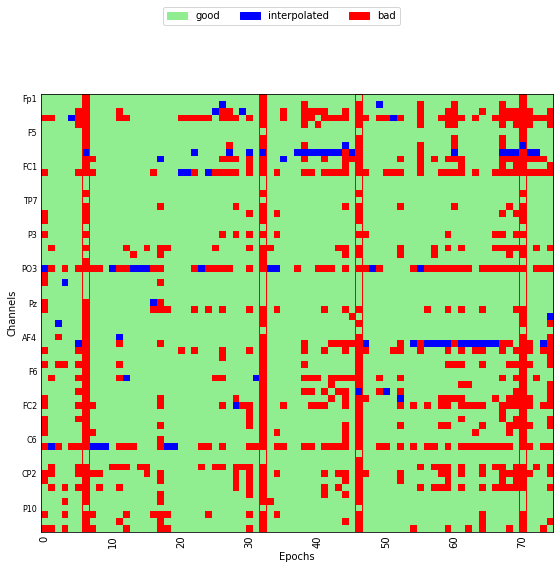

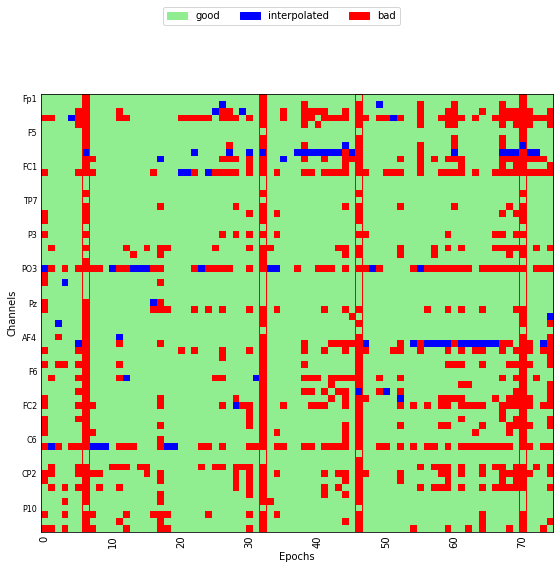

In [112]:
ar = AutoReject()
epochs_clean, reject_log = ar.fit_transform(epochs, return_log=True) 
fig, ax = plt.subplots(figsize=(15,8))
reject_log.plot('horizontal', ax=ax)

# Add Cleaning Log to Report

In [ ]:
# Adding Response Time to Report
#substr = '<p> Response Time: Mean= {:.2f}s | Median= {:.2f}) | Std= {:.2f} </p>'.format(mean_rt/sfreq, std_rt/sfreq, median_rt/sfreq)
#report_subj.add_html(substr, 'Subject Recall/Answer Time')

phases = ['ID', 'Tracking', 'Recall']
stimx = {'ID':0, 'Tracking':2, 'Recall':11}
time_windows = {'ID':(-.2,2), 'Tracking':(1.5, 11), 'Recall':(10.5, 18)}
times_phase = dict()

#cda_phase_cluster_sides_all = dict()
#cda_phase_cluster_sizes_all = dict()
#cda_phase_cluster_perfs_all = dict()

for participant in preproc_dict_all.keys():
    #cda_phase_cluster_sides_all[participant] = dict()
    #cda_phase_cluster_sizes_all[participant] = dict()
    #cda_phase_cluster_perfs_all[participant] = dict()
    
    events = events_dict_all[participant]
    preproc = preproc_dict_all[participant]

    # -- Prep MNE-Report --
    report_subj = mne.Report(title='Subject Report Raw Frequency - {}'.format(participant))
    report_subj_filename = 'Subject_Report-{}.html'.format(participant[:-4])

    print('==================================================')
    print('REMOVING EVENTS ID NOT IN EEG FILE...')
    cur_event_id = copy.deepcopy(event_id)
    newevents_in_file = set(np.array(events_dict_all[participant])[:,2])
    keys_to_delete = []
    for e in cur_event_id.keys():
        if event_id[e] not in newevents_in_file:
            print('Event: {} ({}), not present.'.format(e, event_id[e]))
            keys_to_delete.append(e)
    for key in keys_to_delete:
        del cur_event_id[key]
    print('==================================================')   
        
    epochs = Epochs(preproc, events, event_id=cur_event_id, tmin=-3, tmax=20, baseline=(None, None), preload=True, event_repeated='merge', on_missing='warn')
    
    print('Adding raw to report...')
    report_subj.add_raw(raw=preproc.pick_types(eeg=True), butterfly=False, title='[Subj] Raw (Preproc)')

    print('Adding epochs to report...')
    report_subj.add_epochs(epochs=epochs, title='[Subj] Epochs (Full Trial)')
    
    # ================================
    # TODO: Add Evokeds to MNE-Report
    # ================================
    
    # Adding Response Time to Report
    substr = '<p> Response Time: Mean= {:.2f}s | Median= {:.2f} | Std= {:.2f} </p>'.format(mean_rt/sfreq, std_rt/sfreq, median_rt/sfreq)
    report_subj.add_html(substr, '[Subj] Response Time')
        
    #report_subject_psd(report_subj, epochs)
    #report_subject_psd_color(report_subj, epochs)

    report_subject_ersp(report_subj, epochs)
    #report_subject_ersp_clusters(report_subj, epochs)
    #report_subject_ersp_channels(report_subj, epochs)
    
    #for cur_phase in phases: 
    #    tmin, tmax = time_windows[cur_phase]
    #    epochs = Epochs(preproc, events, event_id=cur_event_id, tmin=tmin, tmax=tmax, baseline=(None, None), preload=True, event_repeated='merge', on_missing='warn')
    #    epochs = mne.set_bipolar_reference(epochs, anode=chan_left_all, cathode=chan_right_all, verbose=False)
    #    times_phase[cur_phase] = epochs.times
        
    #    # ----------------------------------------------------------------------------
    #    print('Doing the sides...')
    #    cda_phase_cluster_sides_all[participant][cur_phase] = dict()
    #    cda_phase_cluster_sides_all[participant][cur_phase]['left'] = dict()
    #    cda_phase_cluster_sides_all[participant][cur_phase]['right'] = dict()
        
    #    for cur_perf in ['good', 'bad', 'all']:
    #        cl_right_trials, cl_left_trials = report_subject_sides(report=report_subj, epochs=epochs, chan_right_all=chan_right_all, chan_left_all=chan_left_all, phase=cur_phase, stimx=stimx[cur_phase], perf=cur_perf) 
    #        cda_phase_cluster_sides_all[participant][cur_phase]['left'][cur_perf] = cl_left_trials
    #        cda_phase_cluster_sides_all[participant][cur_phase]['right'][cur_perf] = cl_right_trials
    #    # ----------------------------------------------------------------------------
        
    #    # ----------------------------------------------------------------------------
    #    print('Doing the sizes...')
    #    cda_phase_cluster_sizes_all[participant][cur_phase] = dict()
    #    cda_phase_cluster_sizes_all[participant][cur_phase]['left'] = dict()
    #    cda_phase_cluster_sizes_all[participant][cur_phase]['right'] = dict()
        
    #    for cur_perf in ['good', 'bad', 'all']:
    #        cl_right_trials, cl_left_trials = report_subject_sizes(report=report_subj, epochs=epochs, chan_right_all=chan_right_all, chan_left_all=chan_left_all, phase=cur_phase, stimx=stimx[cur_phase], perf=cur_perf)
    #        cda_phase_cluster_sizes_all[participant][cur_phase]['left'][cur_perf] = cl_left_trials
    #        cda_phase_cluster_sizes_all[participant][cur_phase]['right'][cur_perf]= cl_right_trials
    #    # ----------------------------------------------------------------------------
        
    #    # ----------------------------------------------------------------------------
    #    print('Doing the perfs...')
    #    cda_phase_cluster_perfs_all[participant][cur_phase] = dict()
        
    #    cl_right_trials, cl_left_trials = report_subject_perfs(report=report_subj, epochs=epochs, chan_right_all=chan_right_all, chan_left_all=chan_left_all, phase=cur_phase, stimx=stimx[cur_phase])
    #    cda_phase_cluster_perfs_all[participant][cur_phase]['left'] = cl_left_trials
    #    cda_phase_cluster_perfs_all[participant][cur_phase]['right'] = cl_right_trials
    #    # ----------------------------------------------------------------------------

    print('Saving report...')
    report_subj.save(report_subj_filename, overwrite=True, open_browser=False)

    print(f'{participant} - Done!')

#times = epochs.copy().crop(tmin=tmin, tmax=tmax).times

Embedding : jquery-3.6.0.min.js
Embedding : bootstrap.bundle.min.js
Embedding : bootstrap.min.css
Embedding : highlightjs/highlight.min.js
Embedding : highlightjs/atom-one-dark-reasonable.min.css
REMOVING EVENTS ID NOT IN EEG FILE...
Not setting metadata
Not setting metadata
84 matching events found
Setting baseline interval to [-3.0, 20.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 84 events and 47105 original time points ...
0 bad epochs dropped
Adding raw to report...
Adding epochs to report...
    Using multitaper spectrum estimation with 7 DPSS windows
[ERSP] Starting...


## Whole Head - PSD

In [8]:
def report_subject_psd(report, epochs):
    print('[PSD] Starting...')
        
    fig, axs = plt.subplots(2, 2, figsize=(15,10))

    # 1. Full Sequence
    psds, freqs = psd_multitaper(epochs['good'].copy().crop(tmin=0, tmax=15), fmin=2, fmax=100, n_jobs=1)
    psds = 10 * np.log10(psds)  # convert to dB
    psds_mean = psds.mean(0).mean(0)
    psds_std = psds.mean(0).std(0)
    axs[0,0].plot(freqs, psds_mean, color='k')
    axs[0,0].fill_between(freqs, psds_mean - psds_std, psds_mean + psds_std, color='k', alpha=.5)
    axs[0,0].set(title='Multitaper PSD - Full Sequence (Good)', xlabel='Frequency (Hz)', ylabel='Power Spectral Density (dB)')

    # 2. ID (Cue)
    psds, freqs = psd_multitaper(epochs['good'].copy().crop(tmin=0, tmax=2), fmin=2, fmax=100, n_jobs=1)
    psds = 10 * np.log10(psds)  # convert to dB
    psds_mean = psds.mean(0).mean(0)
    psds_std = psds.mean(0).std(0)
    axs[0,1].plot(freqs, psds_mean, color='k')
    axs[0,1].fill_between(freqs, psds_mean - psds_std, psds_mean + psds_std, color='k', alpha=.5)
    axs[0,1].set(title='Multitaper PSD - ID (Good)', xlabel='Frequency (Hz)', ylabel='Power Spectral Density (dB)')

    # 3. Tracking
    psds, freqs = psd_multitaper(epochs['good'].copy().crop(tmin=2, tmax=10.5), fmin=2, fmax=100, n_jobs=1)
    psds = 10 * np.log10(psds)  # convert to dB
    psds_mean = psds.mean(0).mean(0)
    psds_std = psds.mean(0).std(0)
    axs[1,0].plot(freqs, psds_mean, color='k')
    axs[1,0].fill_between(freqs, psds_mean - psds_std, psds_mean + psds_std, color='k', alpha=.5)
    axs[1,0].set(title='Multitaper PSD - Tracking (Good)', xlabel='Frequency (Hz)', ylabel='Power Spectral Density (dB)')

    # 4. Recall
    psds, freqs = psd_multitaper(epochs['good'].copy().crop(tmin=10.5, tmax=15), fmin=2, fmax=100, n_jobs=1)
    psds = 10 * np.log10(psds)  # convert to dB
    psds_mean = psds.mean(0).mean(0)
    psds_std = psds.mean(0).std(0)
    axs[1,1].plot(freqs, psds_mean, color='k')
    axs[1,1].fill_between(freqs, psds_mean - psds_std, psds_mean + psds_std, color='k', alpha=.5)
    axs[1,1].set(title='Multitaper PSD - Recall (Good)', xlabel='Frequency (Hz)', ylabel='Power Spectral Density (dB)')

    fig.tight_layout()
    #plt.show()

    print('[PSD] Adding figure...')
    report.add_figure(
    fig=fig, title='[Subj] PSD',#.format(phase, perf.capitalize()),
    caption='[Subj] PSD', #- L vs R ({})'.format(phase, perf.capitalize()),
    tags=('Electrodes','PSD',),
    image_format='PNG')
    
    print('[PSD] Done!')
    

def report_subject_psd_color(report, epochs):   
    print('[PSD] Starting...')
    
    fig, axs = plt.subplots(2, 2, figsize=(15,10))
    
    epochs['good'].copy().crop(tmin=0, tmax=15).plot_psd(fmin=1, fmax=50, ax=axs[0,0])
    epochs['good'].copy().crop(tmin=0, tmax=2).plot_psd(fmin=1, fmax=50, ax=axs[0,1])
    epochs['good'].copy().crop(tmin=2, tmax=10.5).plot_psd(fmin=1, fmax=50, ax=axs[1,0])
    epochs['good'].copy().crop(tmin=10.5, tmax=17).plot_psd(fmin=1, fmax=50, ax=axs[1,1])
    axs[0,0].set_title('PSD - Full Sequence')
    axs[0,1].set_title('PSD - ID')
    axs[1,0].set_title('PSD - Tracking')
    axs[1,1].set_title('PSD - Recall')
    
    fig.tight_layout()
    #plt.show()

    print('[PSD] Adding figure...')
    report_subj.add_figure(
    fig=fig, title='[Subj] PSD',#.format(phase, perf.capitalize()),
    caption='[Subj] PSD', #- L vs R ({})'.format(phase, perf.capitalize()),
    tags=('Electrodes','PSD',),
    image_format='PNG')
    
    print('[PSD] Done!')

## Whole Head - ERSP

In [9]:
def report_subject_ersp(report, epochs):
    print('[ERSP] Starting...')
    
    freqs = np.arange(2, 50, 1)
    n_cycles = freqs / 2.  # different number of cycle per frequency
    power, itc = tfr_morlet(epochs, freqs=freqs, n_cycles=n_cycles, use_fft=True, return_itc=True, decim=3, n_jobs=1)
    power_data_db = 10*np.log10(power.data) # convert to dB
    tf_times = power.times

    fig, axs = plt.subplots(2, 2, figsize=(15,10))

    # Full Sequence
    freq_anal = power_data_db.mean(0) #[ch_id[0], :, :]
    times_of_interest = [0, 2, 11, 15]
    ticks_of_interest = [np.where(power.times >= t)[0][0] for t in times_of_interest]
    #sns.heatmap(ax=axs[0,0], data=freq_anal)#, yticklabels=freqs)
    axs[0,0].imshow(freq_anal, cmap='hot', interpolation='nearest')
    axs[0,0].set_xticks(ticks_of_interest)
    axs[0,0].set_xticklabels(times_of_interest)
    axs[0,0].invert_yaxis()
    axs[0,0].set_title('Full Sequence')

    # ID
    freq_anal = power_data_db[:,:, (power.times > 0) & (power.times < 2)].mean(0)
    times_of_interest = []
    ticks_of_interest = []
    #sns.heatmap(ax=axs[0,1], data=freq_anal)#, yticklabels=freqs)
    axs[0,1].imshow(freq_anal, cmap='hot', interpolation='nearest')
    axs[0,1].set_xticks(ticks_of_interest)
    axs[0,1].set_xticklabels(times_of_interest)
    axs[0,1].invert_yaxis()
    axs[0,1].set_title('ID')

    # Tracking
    freq_anal = power_data_db[:,:, (power.times > 2) & (power.times < 10.5)].mean(0)
    times_of_interest = []
    ticks_of_interest = []
    #sns.heatmap(ax=axs[1,0], data=freq_anal)#, yticklabels=freqs)
    axs[1,0].imshow(freq_anal, cmap='hot', interpolation='nearest')
    axs[1,0].set_xticks(ticks_of_interest)
    axs[1,0].set_xticklabels(times_of_interest)
    axs[1,0].invert_yaxis()
    axs[1,0].set_title('Tracking')

    # Recall
    freq_anal = power_data_db[:,:, (power.times > 10.5) & (power.times < 15)].mean(0)
    times_of_interest = []
    ticks_of_interest = []
    #sns.heatmap(ax=axs[1,1], data=freq_anal)#, yticklabels=freqs)
    axs[1,1].imshow(freq_anal, cmap='hot', interpolation='nearest')
    axs[1,1].set_xticks(ticks_of_interest)
    axs[1,1].set_xticklabels(times_of_interest)
    axs[1,1].invert_yaxis()
    axs[1,1].set_title('Recall')

    fig.tight_layout()
    #plt.show()

    print('[ERSP] Adding figure...')
    report.add_figure(
    fig=fig, title='[Subj] ERSP',#.format(phase, perf.capitalize()),
    caption='[Subj] ERSP', #- L vs R ({})'.format(phase, perf.capitalize()),
    tags=('Electrodes','ERSP',),
    image_format='PNG')

    
    # -------- ITC --------
    fig = itc.plot_topo(title='Inter-Trial coherence', cmap='Reds')
    
    print('[ERSP/ITC] Adding figure...')
    report.add_figure(
    fig=fig, title='[Subj] ITC',#.format(phase, perf.capitalize()),
    caption='[Subj] ITC', #- L vs R ({})'.format(phase, perf.capitalize()),
    tags=('Electrodes','ITC',),
    image_format='PNG')
    
    print('[ERSP] Done!')


## All Channels - ERSP

In [10]:
def report_subject_ersp_channels(report, epochs):
    print('[ERSP] (channels) Starting...')
    
    freqs = np.arange(2, 50, 1)
    n_cycles = freqs / 2.  # different number of cycle per frequency
    power, itc = tfr_morlet(epochs, freqs=freqs, n_cycles=n_cycles, use_fft=True, return_itc=True, decim=3, n_jobs=1)
    tf_times = power.times
    power_data_db = 10*np.log10(power.data)

    # Finding Channels per Cluster
    ch_per_cluster = dict()
    for cl in clusters:
        ch_per_cluster[cl] = []
        for ch in power.info.ch_names:
            if ch.rfind(cl) >= 0:
                ch_per_cluster[cl].append(ch)
    
    # fig, axs = plt.subplots(64, 4, figsize=(14, 64*4)) # Cause big lag/delay. Not sure why...
    for cl in clusters:
        print('[ERSP] Doing Cluster: {} ({})'.format(clusters_names[cl], ch_per_cluster[cl]))
        cl_start_time = time.time()

        fig, axs = plt.subplots(len(ch_per_cluster[cl]), 4, figsize=(len(ch_per_cluster[cl]) * 8, 4))
        
        for i, ch in enumerate(ch_per_cluster[cl]):
            # Full Sequence
            freq_anal = power_data_db[i, :, :]
            times_of_interest = [0, 2, 11, 15]
            ticks_of_interest = [np.where(power.times >= t)[0][0] for t in times_of_interest]
            sns.heatmap(ax=axs[i, 0], data=freq_anal)#, yticklabels=freqs)
            axs[i, 0].set_xticks(ticks_of_interest)
            axs[i, 0].set_xticklabels(times_of_interest)
            axs[i, 0].invert_yaxis()
            axs[i, 0].set_title(f'[{ch}] - Full Sequence')
            axs[i, 0].set_ylabel(ch)

            # ID
            freq_anal = power_data_db[i:,:, (power.times > 0) & (power.times < 2)].mean(0) #[ch_id[0], :, :]
            times_of_interest = []
            ticks_of_interest = []
            sns.heatmap(ax=axs[i, 1], data=freq_anal)#, yticklabels=freqs)
            axs[i, 1].set_xticks(ticks_of_interest)
            axs[i, 1].set_xticklabels(times_of_interest)
            axs[i, 1].invert_yaxis()
            axs[i, 1].set_title(f'[{ch}] - ID') 

            # Tracking
            freq_anal = power_data_db[i:,:, (power.times > 2) & (power.times < 10.5)].mean(0) #[ch_id[0], :, :]
            times_of_interest = []
            ticks_of_interest = []
            sns.heatmap(ax=axs[i, 2], data=freq_anal)#, yticklabels=freqs)
            axs[i, 2].set_xticks(ticks_of_interest)
            axs[i, 2].set_xticklabels(times_of_interest)
            axs[i, 2].invert_yaxis()
            axs[i, 2].set_title(f'[{ch}] - Tracking')

            # Recall
            freq_anal = power_data_db[i:,:, (power.times > 10.5) & (power.times < 15)].mean(0) #[ch_id[0], :, :]
            times_of_interest = []
            ticks_of_interest = []
            sns.heatmap(ax=axs[i, 3], data=freq_anal)#, yticklabels=freqs)
            axs[i, 3].set_xticks(ticks_of_interest)
            axs[i, 3].set_xticklabels(times_of_interest)
            axs[i, 3].invert_yaxis()
            axs[i, 3].set_title(f'[{ch}] - Recall')

        fig.tight_layout()
        plt.show()

        print('Adding figure...')
        report.add_figure(
        fig=fig, title='[Subj] ERSP - {}'.format(clusters_names[cl]),#.format(phase, perf.capitalize()),
        caption='[Subj] ERSP - {}'.format(clusters_names[cl]), #- L vs R ({})'.format(phase, perf.capitalize()),
        tags=('Electrodes','ERSP',),
        image_format='PNG')
    
        print('[ERSP] Cluster: {}, done! ({})'.format(clusters_names[cl], time.time() - cl_start_time))
    
    print('[ERSP] (channels) Done!')

In [11]:
def report_subject_ersp_clusters(report, epochs):
    print('[ERSP] (clusters) Starting...')
    
    print('[ERSP] (clusters) Calculating Power.')
    freqs = np.arange(2, 50, 1)
    n_cycles = freqs / 2.  # different number of cycle per frequency
    power, itc = tfr_morlet(epochs, freqs=freqs, n_cycles=n_cycles, use_fft=True, return_itc=True, decim=3, n_jobs=1)
    tf_times = power.times
    power_data_db = 10*np.log10(power.data)
    print('[ERSP] (clusters) Done Calculating Power!')
    
    # Finding Channels per Cluster
    ch_per_cluster = dict()
    for cl in clusters:
        ch_per_cluster[cl] = []
        for ch in power.info.ch_names:
            if ch.rfind(cl) >= 0:
                ch_per_cluster[cl].append(ch)
    
    fig, axs = plt.subplots(len(ch_per_cluster[cl]), 4, figsize=(16, len(ch_per_cluster[cl]) * 4))
    for cl in clusters:
        print('[ERSP] Doing Cluster: {} ({})'.format(clusters_names[cl], ch_per_cluster[cl]))
        cl_start_time = time.time()
        
        freq_anal = dict()
        freq_full = np.array([])
        freq_id = np.array([])
        freq_tracking = np.array([])
        freq_recall = np.array([])
        
        for i, ch in enumerate(ch_per_cluster[cl]):
            cur_full = power_data_db[i, :, :]
            cur_id = power_data_db[i, :, (power.times > 0) & (power.times < 2)]
            cur_tracking = power_data_db[i, :, (power.times > 2) & (power.times < 10.5)]
            cur_recall = power_data_db[i, :, (power.times > 10.5) & (power.times < 15)]
            
            freq_full =  np.vstack((freq_full, cur_full)) if len(freq_full) else cur_full
            freq_id = np.vstack((freq_id, cur_id)) if len(freq_id) else cur_id
            freq_tracking = np.vstack((freq_tracking, cur_tracking)) if len(freq_tracking) else cur_tracking
            freq_recall = np.vstack((freq_recall, cur_recall)) if len(freq_recall) else cur_recall
            
        # Getting the Cluster Average.
        freq_anal["Full"] = freq_full.mean(0)
        freq_anal["ID"] = freq_id.mean(0)
        freq_anal["Tracking"] = freq_tracking.mean(0)
        freq_anal["Recall"] = freq_recall.mean(0)

        # Full Sequence
        times_of_interest = [0, 2, 11, 15]
        ticks_of_interest = [np.where(power.times >= t)[0][0] for t in times_of_interest]
        sns.heatmap(ax=axs[0], data=freq_anal["Full"])#, yticklabels=freqs)
        axs[0].set_xticks(ticks_of_interest)
        axs[0].set_xticklabels(times_of_interest)
        axs[0].invert_yaxis()
        axs[0].set_title(f'[{ch}] - Full Sequence')
        axs[0].set_ylabel(ch)

        # ID
        times_of_interest = []
        ticks_of_interest = []
        sns.heatmap(ax=axs[1], data=freq_anal["ID"])#, yticklabels=freqs)
        axs[1].set_xticks([ticks_of_interest])
        axs[1].set_xticklabels(times_of_interest)
        axs[1].invert_yaxis()
        axs[1].set_title(f'[{ch}] - ID') 

        # Tracking
        times_of_interest = []
        ticks_of_interest = []
        sns.heatmap(ax=axs[2], data=freq_anal["Tracking"])#, yticklabels=freqs)
        axs[2].set_xticks(ticks_of_interest)
        axs[2].set_xticklabels(times_of_interest)
        axs[2].invert_yaxis()
        axs[2].set_title(f'[{ch}] - Tracking')

        # Recall
        times_of_interest = []
        ticks_of_interest = []
        sns.heatmap(ax=axs[3], data=freq_anal["Recall"])#, yticklabels=freqs)
        axs[3].set_xticks(ticks_of_interest)
        axs[3].set_xticklabels(times_of_interest)
        axs[3].invert_yaxis()
        axs[3].set_title(f'[{ch}] - Recall')

        fig.tight_layout()
        plt.show()

        print('Adding figure...')
        report.add_figure(
        fig=fig, title='[Subj] ERSP - {}'.format(clusters_names[cl]),#.format(phase, perf.capitalize()),
        caption='[Subj] ERSP - {}'.format(clusters_names[cl]), #- L vs R ({})'.format(phase, perf.capitalize()),
        tags=('Electrodes','ERSP',),
        image_format='PNG')
    
        print('[ERSP] Cluster: {}, done! ({})'.format(clusters_names[cl], time.time() - cl_start_time))
    
    print('[ERSP] (channels) Done!')

## Whole Head - Topo

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)


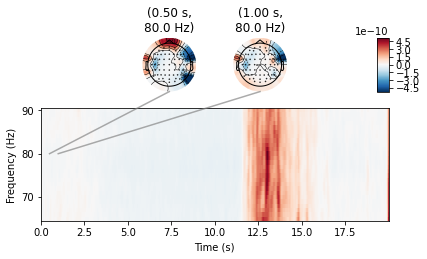

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)


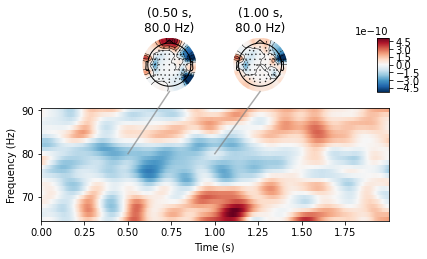

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)


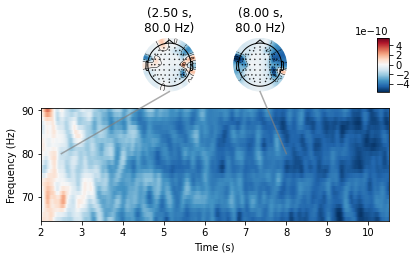

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)


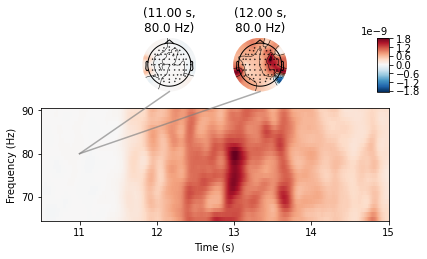

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)


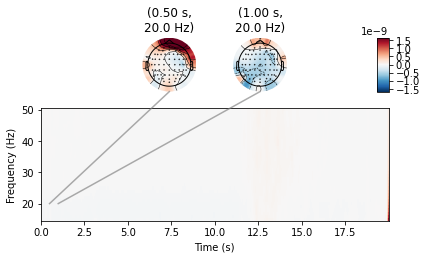

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)


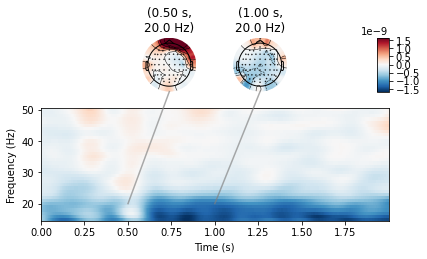

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)


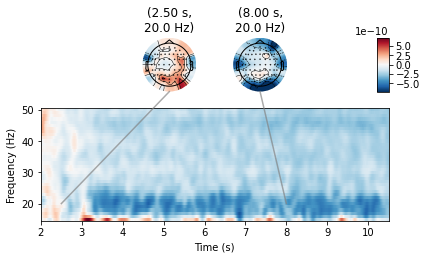

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)


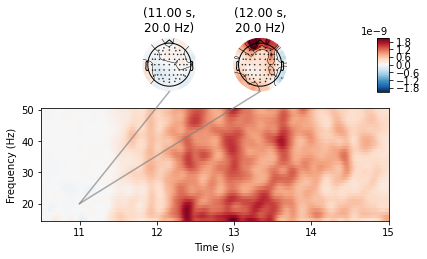

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)


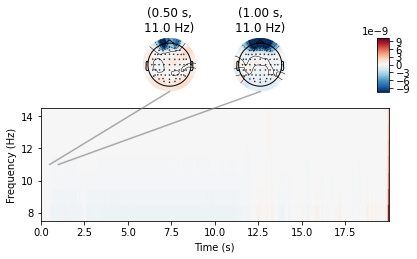

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)


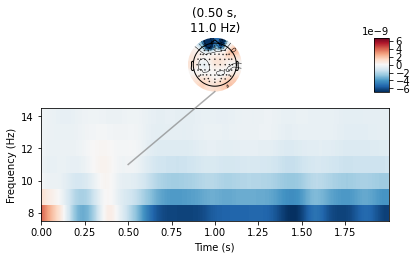

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)


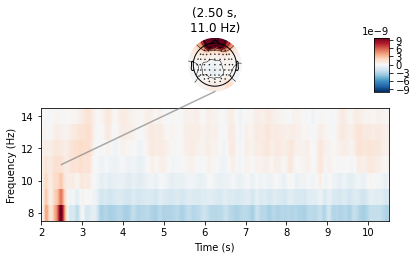

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)


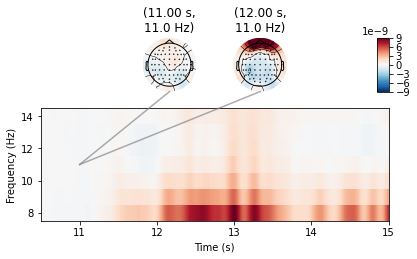

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)


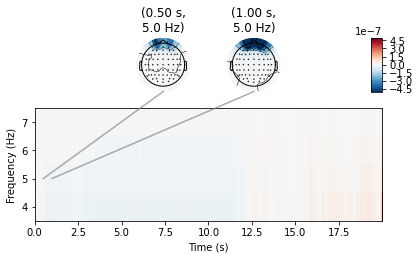

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)


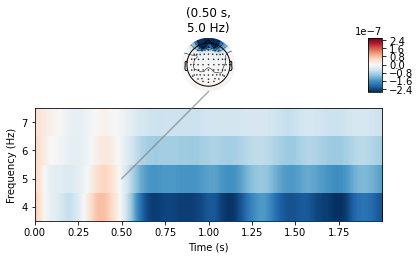

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)


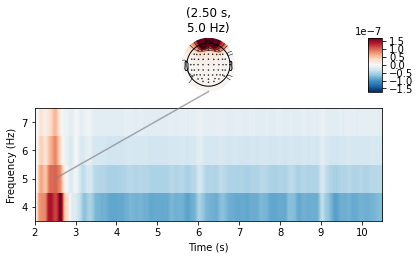

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)


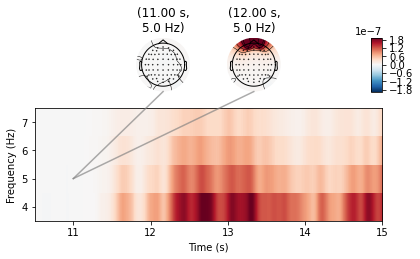

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)


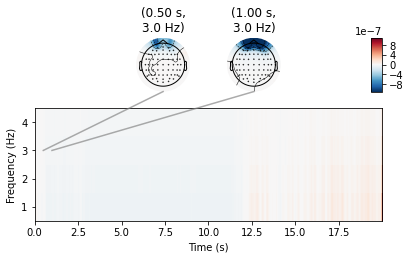

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)


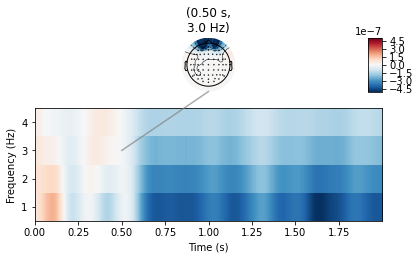

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)


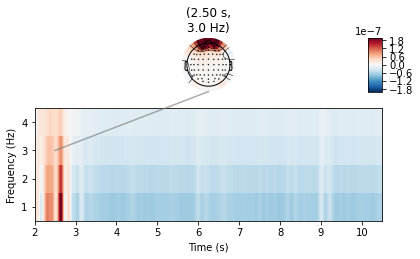

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)


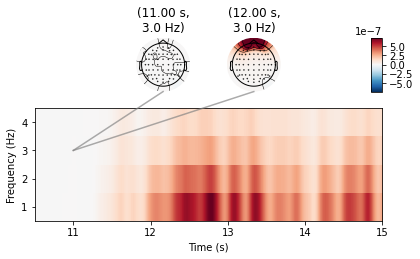

In [95]:
%matplotlib inline

#freqs2 = np.arange(1, 100, 1)
#n_cycles2 = freqs2 / 2.  # different number of cycle per frequency
#power2, itc2 = tfr_morlet(epochs_freq, freqs=freqs2, n_cycles=n_cycles2, use_fft=True, return_itc=True, decim=3, n_jobs=-1)
#tf_times2 = power2.times

# High Gamma
x = power2.plot_joint(dB=False, baseline=(-0.5, 0), mode='mean', tmin=0, tmax=20, fmin=65, fmax=90, timefreqs=[(0.5, 80), (1.0, 80)])
x = power2.plot_joint(dB=False, baseline=(-0.5, 0), mode='mean', tmin=0, tmax=2, fmin=65, fmax=90, timefreqs=[(0.5, 80), (1.0, 80)])
x = power2.plot_joint(dB=False, baseline=(1.5, 2), mode='mean', tmin=2, tmax=10.5, fmin=65, fmax=90, timefreqs=[(2.5, 80), (8, 80)])
x = power2.plot_joint(dB=False, baseline=(10, 10.5), mode='mean', tmin=10.5, tmax=15, fmin=65, fmax=90, timefreqs=[(11, 80), (12, 80)])

# Beta & Gamma
x = power2.plot_joint(dB=False, baseline=(-0.5, 0), mode='mean', tmin=0, tmax=20, fmin=15, fmax=50, timefreqs=[(0.5, 20), (1.0, 20)])
x = power2.plot_joint(dB=False, baseline=(-0.5, 0), mode='mean', tmin=0, tmax=2, fmin=15, fmax=50, timefreqs=[(0.5, 20), (1.0, 20)])
x = power2.plot_joint(dB=False, baseline=(1.5, 2), mode='mean', tmin=2, tmax=10.5, fmin=15, fmax=50, timefreqs=[(2.5, 20), (8, 20)])
x = power2.plot_joint(dB=False, baseline=(10, 10.5), mode='mean', tmin=10.5, tmax=15, fmin=15, fmax=50, timefreqs=[(11, 20), (12, 20)])

# Alpha
x = power2.plot_joint(dB=False, baseline=(-0.5, 0), mode='mean', tmin=0, tmax=20, fmin=8, fmax=14, timefreqs=[(0.5, 11), (1.0, 11)])
x = power2.plot_joint(dB=False, baseline=(-0.5, 0), mode='mean', tmin=0, tmax=2, fmin=8, fmax=14, timefreqs=[(0.5, 11)])
x = power2.plot_joint(dB=False, baseline=(1.5, 2), mode='mean', tmin=2, tmax=10.5, fmin=8, fmax=14, timefreqs=[(2.5, 11)])
x = power2.plot_joint(dB=False, baseline=(10, 10.5), mode='mean', tmin=10.5, tmax=15, fmin=8, fmax=14, timefreqs=[(11, 11), (12, 11)])

# Theta
x = power2.plot_joint(dB=False, baseline=(-0.5, 0), mode='mean', tmin=0, tmax=20, fmin=4, fmax=7, timefreqs=[(0.5, 5), (1.0, 5)])
x = power2.plot_joint(dB=False, baseline=(-0.5, 0), mode='mean', tmin=0, tmax=2, fmin=4, fmax=7, timefreqs=[(0.5, 5)])
x = power2.plot_joint(dB=False, baseline=(1.5, 2), mode='mean', tmin=2, tmax=10.5, fmin=4, fmax=7, timefreqs=[(2.5, 5)])
x = power2.plot_joint(dB=False, baseline=(10, 10.5), mode='mean', tmin=10.5, tmax=15, fmin=4, fmax=7, timefreqs=[(11, 5), (12, 5)])

# Delta
x = power2.plot_joint(dB=False, baseline=(-0.5, 0), mode='mean', tmin=0, tmax=20, fmin=1, fmax=4, timefreqs=[(0.5, 3), (1.0, 3)])
x = power2.plot_joint(dB=False, baseline=(-0.5, 0), mode='mean', tmin=0, tmax=2, fmin=1, fmax=4, timefreqs=[(0.5, 3)])
x = power2.plot_joint(dB=False, baseline=(1.5, 2), mode='mean', tmin=2, tmax=10.5, fmin=1, fmax=4, timefreqs=[(2.5, 3)])
x = power2.plot_joint(dB=False, baseline=(10, 10.5), mode='mean', tmin=10.5, tmax=15, fmin=1, fmax=4, timefreqs=[(11, 3), (12, 3)])

    Using multitaper spectrum estimation with 7 DPSS windows


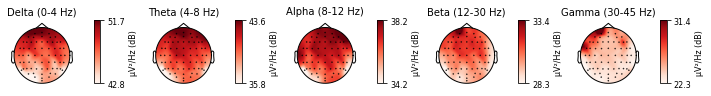

    Using multitaper spectrum estimation with 7 DPSS windows


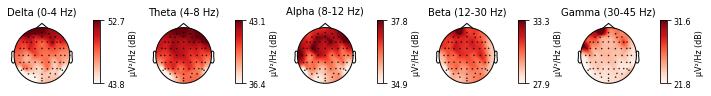

In [128]:
x = epochs['right'].crop(tmin=0, tmax=1.8).plot_psd_topomap(ch_type='eeg', normalize=False)
x = epochs['left'].crop(tmin=0, tmax=1.8).plot_psd_topomap(ch_type='eeg', normalize=False)

    Using multitaper spectrum estimation with 7 DPSS windows


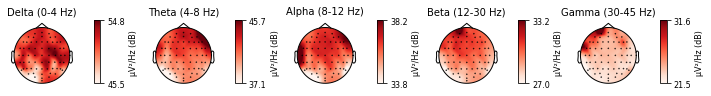

    Using multitaper spectrum estimation with 7 DPSS windows


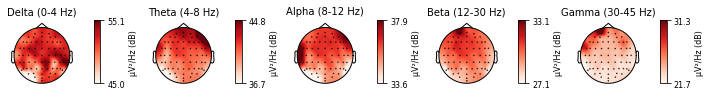

In [129]:
x = epochs['good'].crop(tmin=2, tmax=10).plot_psd_topomap(ch_type='eeg', normalize=False)
x = epochs['bad'].crop(tmin=2, tmax=10).plot_psd_topomap(ch_type='eeg', normalize=False)

    Using multitaper spectrum estimation with 7 DPSS windows


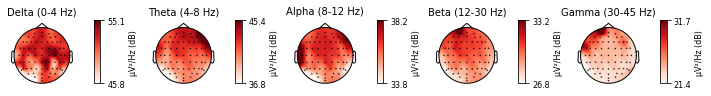

    Using multitaper spectrum estimation with 7 DPSS windows


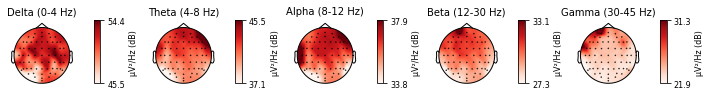

    Using multitaper spectrum estimation with 7 DPSS windows


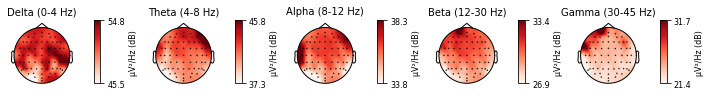

In [130]:
x = epochs['1'].crop(tmin=2, tmax=10).plot_psd_topomap(ch_type='eeg', normalize=False)
x = epochs['2'].crop(tmin=2, tmax=10).plot_psd_topomap(ch_type='eeg', normalize=False)
x = epochs['3'].crop(tmin=2, tmax=10).plot_psd_topomap(ch_type='eeg', normalize=False)

## Whole Head - ITC

# Connectivity

In [127]:
from mne_connectivity import spectral_connectivity
from mne_connectivity.viz import plot_sensors_connectivity

# Compute connectivity for band containing the evoked response.
# We exclude the baseline period:
fmin, fmax = 75, 85.
sfreq = raw.info['sfreq']  # the sampling frequency
tmin = 0.0  # exclude the baseline period
epochs.pick_types(eeg=True)  # just keep MEG and no EOG now
con = spectral_connectivity(epochs['right'].copy().crop(tmin=10.5, tmax=13.5), method='pli', mode='multitaper', sfreq=sfreq, fmin=fmin, fmax=fmax,
    faverage=True, tmin=tmin, mt_adaptive=False, n_jobs=8)

# Now, visualize the connectivity in 3D:
fig = plot_sensors_connectivity(epochs.info, con.get_data(output='dense')[:, :, 0], cbar_label='Connectivity')

Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 2016 connections
    using t=10.500s..13.500s for estimation (6145 points)
    frequencies: 75.3Hz..85.0Hz (30 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: PLI
    computing connectivity for epochs 1..8


/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_78279/3467086375.py:10: RuntimeWarning: start time tmin=0.00 s outside of the time scope of the data [10.50 s, 13.50 s]
  con = spectral_connectivity(epochs['right'].copy().crop(tmin=10.5, tmax=13.5), method='pli', mode='multitaper', sfreq=sfreq, fmin=fmin, fmax=fmax,
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.2s remaining:    0.1s


    computing connectivity for epochs 9..16
    computing connectivity for epochs 17..24


[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


    computing connectivity for epochs 25..26
    assembling connectivity matrix
[Connectivity computation done]


[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.1s finished
Context leak detected, msgtracer returned -1


In [ ]:
import os.path as op
import mne

sample_path = mne.datasets.sample.data_path()
subjects_dir = op.join(sample_path, 'subjects')
fname_evoked = op.join(sample_path, 'MEG', 'sample', 'sample_audvis-ave.fif')
fname_inv = op.join(sample_path, 'MEG', 'sample',
                    'sample_audvis-meg-oct-6-meg-inv.fif')
fname_trans = op.join(sample_path, 'MEG', 'sample',
                      'sample_audvis_raw-trans.fif')
inv = mne.minimum_norm.read_inverse_operator(fname_inv)
evoked = mne.read_evokeds(fname_evoked, baseline=(None, 0),
                          proj=True, verbose=False, condition='Left Auditory')
maps = mne.make_field_map(evoked, trans=fname_trans, ch_type='meg',
                          subject='sample', subjects_dir=subjects_dir)
time = 0.083
fig = mne.viz.create_3d_figure((256, 256))
mne.viz.plot_alignment(
    evoked.info, subject='sample', subjects_dir=subjects_dir, fig=fig,
    trans=fname_trans, meg='sensors', eeg=False, surfaces='pial',
    coord_frame='mri')
evoked.plot_field(maps, time=time, fig=fig, time_label=None, vmax=5e-13)
mne.viz.set_3d_view(
    fig, azimuth=40, elevation=87, focalpoint=(0., -0.01, 0.04), roll=-25,
    distance=0.55)

In [91]:
from mne.time_frequency import csd_fourier, csd_multitaper, csd_morlet

%matplotlib qt

#fig, ax = plt.subplots(figsize=(15,15))
csd_fft = csd_fourier(epochs['left'].copy().crop(tmin=10.5, tmax=13), fmin=2, fmax=90, n_jobs=1)
#csd_fft.mean().plot()
#csd_fft.pick_frequency(freq=80).plot()
csd_fft.mean().plot()

Computing cross-spectral density from epochs...


100%|██████████████████████████████████████| CSD epoch blocks : 30/30 [00:00<00:00,   30.05it/s]

[done]


[<Figure size 432x316 with 2 Axes>]

In [11]:
%matplotlib qt

fig = plot_sensors_connectivity(epochs.info, con.get_data(output='dense')[:, :, 0], cbar_label='Connectivity')

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_77720/721097237.py:3: DeprecationWarning: The Mayavi 3D backend is deprecated in 0.24 and will be removed in the next version of MNE-Python. Use the pyvistaqt or notebook backends instead
  fig = plot_sensors_connectivity(epochs.info, con.get_data(output='dense')[:, :, 0], cbar_label='Connectivity')
qt.qpa.window: <QNSWindow: 0x7f7bbbdc4540; contentView=<QNSView: 0x7f7bbbdc4130; QCocoaWindow(0x600003739e40, window=QWidgetWindow(0x60000250d680, name="QMainWindowClassWindow"))>> has active key-value observers (KVO)! These will stop working now that the window is recreated, and will result in exceptions when the observers are removed. Break in QCocoaWindow::recreateWindowIfNeeded to debug.


This object has no color map


AttributeError: 'NoneType' object has no attribute 'label_text_property'

## Mean/Median Power

Effective window size : 0.125 (s)
Effective window size : 0.125 (s)


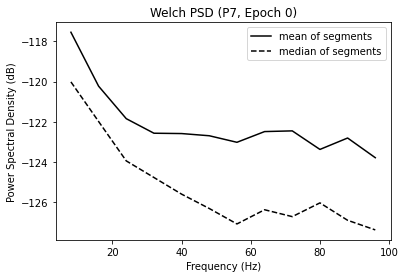

In [38]:
# Estimate PSDs based on "mean" and "median" averaging for comparison.
kwargs = dict(fmin=2, fmax=100, n_jobs=1)
psds_welch_mean, freqs_mean = psd_welch(epochs, average='mean', **kwargs)
psds_welch_median, freqs_median = psd_welch(epochs, average='median', **kwargs)

# Convert power to dB scale.
psds_welch_mean = 10 * np.log10(psds_welch_mean)
psds_welch_median = 10 * np.log10(psds_welch_median)

# We will only plot the PSD for a single sensor in the first epoch.
ch_name = 'P7'
ch_idx = epochs.info['ch_names'].index(ch_name)
epo_idx = 0

_, ax = plt.subplots()
ax.plot(freqs_mean, psds_welch_mean[epo_idx, ch_idx, :], color='k',
        ls='-', label='mean of segments')
ax.plot(freqs_median, psds_welch_median[epo_idx, ch_idx, :], color='k',
        ls='--', label='median of segments')

ax.set(title='Welch PSD ({}, Epoch {})'.format(ch_name, epo_idx),
       xlabel='Frequency (Hz)', ylabel='Power Spectral Density (dB)')
ax.legend(loc='upper right')
plt.show()

Effective window size : 0.125 (s)
Effective window size : 0.125 (s)


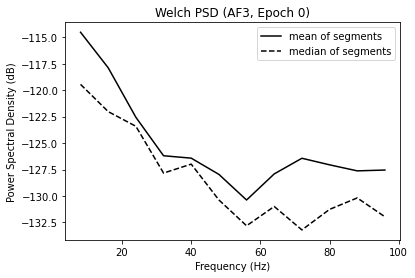

In [40]:
# Estimate PSDs based on "mean" and "median" averaging for comparison.
kwargs = dict(fmin=2, fmax=100, n_jobs=1)
psds_welch_mean, freqs_mean = psd_welch(epochs.copy().crop(tmin=0, tmax=2), average='mean', **kwargs)
psds_welch_median, freqs_median = psd_welch(epochs.copy().crop(tmin=0, tmax=2), average='median', **kwargs)

# Convert power to dB scale.
psds_welch_mean = 10 * np.log10(psds_welch_mean)
psds_welch_median = 10 * np.log10(psds_welch_median)

# We will only plot the PSD for a single sensor in the first epoch.
ch_name = 'AF3'
ch_idx = epochs.info['ch_names'].index(ch_name)
epo_idx = 0

_, ax = plt.subplots()
ax.plot(freqs_mean, psds_welch_mean[epo_idx, ch_idx, :], color='k',
        ls='-', label='mean of segments')
ax.plot(freqs_median, psds_welch_median[epo_idx, ch_idx, :], color='k',
        ls='--', label='median of segments')

ax.set(title='Welch PSD ({}, Epoch {})'.format(ch_name, epo_idx),
       xlabel='Frequency (Hz)', ylabel='Power Spectral Density (dB)')
ax.legend(loc='upper right')
plt.show()

Effective window size : 0.125 (s)
Effective window size : 0.125 (s)


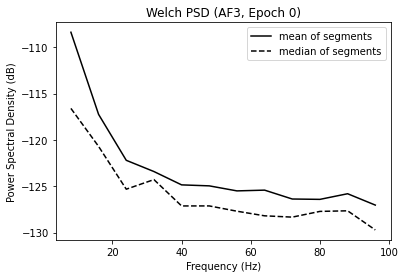

In [41]:
# Estimate PSDs based on "mean" and "median" averaging for comparison.
kwargs = dict(fmin=2, fmax=100, n_jobs=1)
psds_welch_mean, freqs_mean = psd_welch(epochs.copy().crop(tmin=2, tmax=10), average='mean', **kwargs)
psds_welch_median, freqs_median = psd_welch(epochs.copy().crop(tmin=2, tmax=10), average='median', **kwargs)

# Convert power to dB scale.
psds_welch_mean = 10 * np.log10(psds_welch_mean)
psds_welch_median = 10 * np.log10(psds_welch_median)

# We will only plot the PSD for a single sensor in the first epoch.
ch_name = 'AF3'
ch_idx = epochs.info['ch_names'].index(ch_name)
epo_idx = 0

_, ax = plt.subplots()
ax.plot(freqs_mean, psds_welch_mean[epo_idx, ch_idx, :], color='k',
        ls='-', label='mean of segments')
ax.plot(freqs_median, psds_welch_median[epo_idx, ch_idx, :], color='k',
        ls='--', label='median of segments')

ax.set(title='Welch PSD ({}, Epoch {})'.format(ch_name, epo_idx),
       xlabel='Frequency (Hz)', ylabel='Power Spectral Density (dB)')
ax.legend(loc='upper right')
plt.show()

In [55]:
# define frequencies of interest (log-spaced)
freqs = np.logspace(*np.log10([3, 100]), num=20)
n_cycles = freqs / 2.  # different number of cycle per frequency
power, itc = tfr_morlet(epochs['right'].copy().crop(tmin=2, tmax=10), freqs=freqs, n_cycles=n_cycles, use_fft=True,
                        return_itc=True, decim=3, n_jobs=1)

In [56]:
%matplotlib qt 

power.plot_topo(baseline=(-0.5, 0), mode='logratio', title='Average power')
power.plot([44], baseline=(-0.5, 0), mode='logratio', title=power.ch_names[44])

fig, axis = plt.subplots(1, 2, figsize=(7, 4))
power.plot_topomap(ch_type='eeg', tmin=0.5, tmax=1.5, fmin=8, fmax=12,
                   baseline=(-0.5, 0), mode='logratio', axes=axis[0],
                   title='Alpha', show=False)
power.plot_topomap(ch_type='eeg', tmin=0.5, tmax=1.5, fmin=13, fmax=25,
                   baseline=(-0.5, 0), mode='logratio', axes=axis[1],
                   title='Beta', show=False)
mne.viz.tight_layout()
plt.show()

Applying baseline correction (mode: logratio)


ValueError: bmax is too small (0), it is smaller than the smallest time value

# Non Param Cluster TF Analysis
http://predictablynoisy.com/mne-python/auto_tutorials/plot_stats_cluster_time_frequency.html#sphx-glr-auto-tutorials-plot-stats-cluster-time-frequency-py

In [60]:
from mne.stats import permutation_cluster_test

decim = 2
frequencies = np.arange(3, 80, 2)  # define frequencies of interest
n_cycles = frequencies/2.0

tfr_epochs_1 = tfr_morlet(epochs['good'].pick_channels(['P7']), frequencies,
                          n_cycles=n_cycles, decim=decim,
                          return_itc=False, average=False)

tfr_epochs_2 = tfr_morlet(epochs['bad'].pick_channels(['P7']), frequencies,
                          n_cycles=n_cycles, decim=decim,
                          return_itc=False, average=False)

tfr_epochs_1.apply_baseline(mode='ratio', baseline=(None, 0))
tfr_epochs_2.apply_baseline(mode='ratio', baseline=(None, 0))

epochs_power_1 = tfr_epochs_1.data[:, 0, :, :]  # only 1 channel as 3D matrix
epochs_power_2 = tfr_epochs_2.data[:, 0, :, :]  # only 1 channel as 3D matrix

threshold = 6.0
T_obs, clusters, cluster_p_values, H0 = \
    permutation_cluster_test([epochs_power_1, epochs_power_2],
                             n_permutations=100, threshold=threshold, tail=0)

stat_fun(H1): min=0.000000 max=14.076760
Running initial clustering
Found 101 clusters
Permuting 99 times...


100%|███████████████████████████████████████████████████████████████████████|  : 99/99 [00:19<00:00,    5.17it/s]

Computing cluster p-values
Done.


In [62]:
times = 1e3 * epochs['good'].pick_channels(['P7']).times  # change unit to ms
evoked_condition_1 = epochs['good'].pick_channels(['P7']).average()
evoked_condition_2 = epochs['bad'].pick_channels(['P7']).average()

plt.figure()
plt.subplots_adjust(0.12, 0.08, 0.96, 0.94, 0.2, 0.43)

plt.subplot(2, 1, 1)
# Create new stats image with only significant clusters
T_obs_plot = np.nan * np.ones_like(T_obs)
for c, p_val in zip(clusters, cluster_p_values):
    if p_val <= 0.05:
        T_obs_plot[c] = T_obs[c]

plt.imshow(T_obs,
           extent=[times[0], times[-1], frequencies[0], frequencies[-1]],
           aspect='auto', origin='lower', cmap='gray')
plt.imshow(T_obs_plot,
           extent=[times[0], times[-1], frequencies[0], frequencies[-1]],
           aspect='auto', origin='lower', cmap='RdBu_r')

plt.xlabel('Time (ms)')
plt.ylabel('Frequency (Hz)')
plt.title('Induced power (%s)' % ch_name)

ax2 = plt.subplot(2, 1, 2)
evoked_contrast = mne.combine_evoked([evoked_condition_1, evoked_condition_2],
                                     weights=[1, -1])
evoked_contrast.plot(axes=ax2)

plt.show()

Need more than one channel to make topography for eeg. Disabling interactivity.


    Using multitaper spectrum estimation with 7 DPSS windows


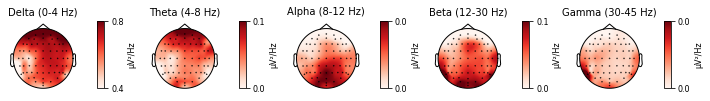

    Using multitaper spectrum estimation with 7 DPSS windows


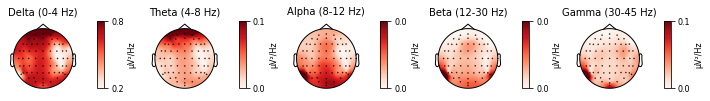

In [93]:
x = epochs['right'].crop(tmin=0, tmax=1.8).plot_psd_topomap(ch_type='eeg', normalize=True)
x = epochs['left'].crop(tmin=0, tmax=1.8).plot_psd_topomap(ch_type='eeg', normalize=True)

    Using multitaper spectrum estimation with 7 DPSS windows


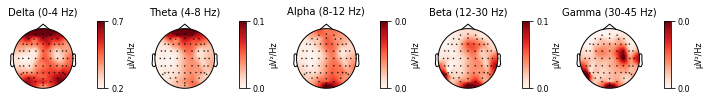

    Using multitaper spectrum estimation with 7 DPSS windows


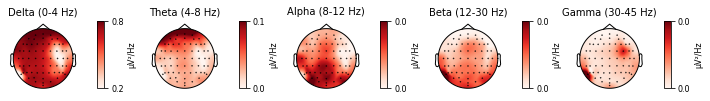

    Using multitaper spectrum estimation with 7 DPSS windows


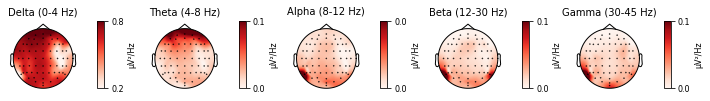

In [109]:
x = epochs['3/left/good'].crop(tmin=0, tmax=1.8).plot_psd_topomap(ch_type='eeg', normalize=True)
x = epochs['2/left/good'].crop(tmin=0, tmax=1.8).plot_psd_topomap(ch_type='eeg', normalize=True)
x = epochs['1/left/good'].crop(tmin=0, tmax=1.8).plot_psd_topomap(ch_type='eeg', normalize=True)

    Using multitaper spectrum estimation with 7 DPSS windows


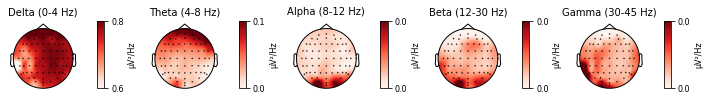

    Using multitaper spectrum estimation with 7 DPSS windows


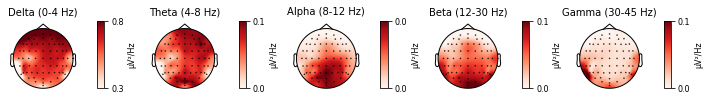

    Using multitaper spectrum estimation with 7 DPSS windows


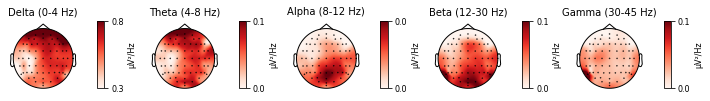

In [110]:
x = epochs['3/right/good'].crop(tmin=0, tmax=1.8).plot_psd_topomap(ch_type='eeg', normalize=True)
x = epochs['2/right/good'].crop(tmin=0, tmax=1.8).plot_psd_topomap(ch_type='eeg', normalize=True)
x = epochs['1/right/good'].crop(tmin=0, tmax=1.8).plot_psd_topomap(ch_type='eeg', normalize=True)

# Hypothesis Driven - Stats

In [208]:
dfp = power.to_data_frame(index='freq')
dfp

,time,Fp1,AF7,AF3,F1,F3,F5,F7,FT7,FC5,...,CP4,CP2,P2,P4,P6,P8,P10,PO8,PO4,O2
freq,,,,,,,,,,,,,,,,,,,,,
20.0,0,3.558745e-08,1.239696e-08,1.171220e-08,4.347115e-09,4.626736e-09,3.791931e-09,3.973762e-09,2.217828e-09,4.462601e-09,...,1.891101e-09,1.513873e-09,1.653050e-09,1.539803e-09,1.598811e-09,1.698637e-09,1.622863e-09,4.525077e-09,2.446248e-09,2.678882e-09
20.0,1,3.560516e-08,1.241275e-08,1.173008e-08,4.361055e-09,4.645963e-09,3.807574e-09,3.987787e-09,2.229687e-09,4.472058e-09,...,1.902110e-09,1.525624e-09,1.662732e-09,1.549872e-09,1.608366e-09,1.709785e-09,1.637637e-09,4.528953e-09,2.453441e-09,2.685992e-09
20.0,3,3.559938e-08,1.242056e-08,1.174047e-08,4.372495e-09,4.662623e-09,3.821064e-09,3.999503e-09,2.240338e-09,4.478743e-09,...,1.912216e-09,1.536756e-09,1.671643e-09,1.559252e-09,1.617154e-09,1.720134e-09,1.651736e-09,4.530031e-09,2.459319e-09,2.691645e-09
20.0,4,3.557014e-08,1.242040e-08,1.174337e-08,4.381431e-09,4.676707e-09,3.832390e-09,4.008900e-09,2.249769e-09,4.482654e-09,...,1.921418e-09,1.547265e-09,1.679782e-09,1.567942e-09,1.625172e-09,1.729679e-09,1.665147e-09,4.528325e-09,2.463889e-09,2.695848e-09
20.0,6,3.551754e-08,1.241227e-08,1.173880e-08,4.387865e-09,4.688208e-09,3.841545e-09,4.015975e-09,2.257973e-09,4.483794e-09,...,1.929713e-09,1.557149e-09,1.687149e-09,1.575942e-09,1.632419e-09,1.738413e-09,1.677863e-09,4.523855e-09,2.467160e-09,2.698612e-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150.0,19994,8.088932e-10,4.627578e-10,5.761380e-10,1.423179e-10,2.626978e-10,1.883488e-10,1.737899e-10,3.523283e-10,4.518595e-10,...,1.832519e-10,1.535180e-10,1.804454e-10,1.537146e-10,3.418974e-10,3.397294e-10,9.913782e-10,2.007279e-10,1.582427e-10,1.416491e-10
150.0,19995,8.085369e-10,4.608290e-10,5.750497e-10,1.417272e-10,2.613717e-10,1.859894e-10,1.717754e-10,3.499059e-10,4.500950e-10,...,1.823213e-10,1.529112e-10,1.802138e-10,1.531449e-10,3.412963e-10,3.386812e-10,9.731575e-10,1.998296e-10,1.573976e-10,1.408633e-10
150.0,19997,8.076978e-10,4.586725e-10,5.736431e-10,1.410682e-10,2.599231e-10,1.835896e-10,1.697218e-10,3.473513e-10,4.481121e-10,...,1.813036e-10,1.522240e-10,1.798832e-10,1.524987e-10,3.405000e-10,3.374562e-10,9.548836e-10,1.988305e-10,1.564764e-10,1.400130e-10


In [188]:
subdfp = dfp[['P4']]
subdfp

,P4
freq,
1.0,1.435404e-07
1.0,1.432588e-07
1.0,1.428801e-07
1.0,1.424053e-07
1.0,1.418356e-07
...,...
100.0,3.634664e-10
100.0,3.623672e-10
100.0,3.610880e-10


In [189]:
sns.heatmap(subdfp)

<AxesSubplot:ylabel='freq'>

In [91]:
from matplotlib.colors import TwoSlopeNorm
import seaborn as sns
from mne.time_frequency import tfr_multitaper
from mne.stats import permutation_cluster_1samp_test as pcluster_test

freqs = np.arange(2, 36)  # frequencies from 2-35Hz
vmin, vmax = -1, 1.5  # set min and max ERDS values in plot
baseline = [-1, 0]  # baseline interval (in s)
cnorm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)  # min, center & max ERDS

kwargs = dict(n_permutations=100, step_down_p=0.05, seed=1,
              buffer_size=None, out_type='mask')  # for cluster test


tfr = tfr_multitaper(epochs_clean, freqs=freqs, n_cycles=freqs, use_fft=True,
                     return_itc=False, average=False, decim=2)
tfr.crop(tmin, tmax).apply_baseline(baseline, mode="percent")

for event in ['left', 'right']:
    # select desired epochs for visualization
    tfr_ev = tfr[event]
    fig, axes = plt.subplots(1, 7, figsize=(12, 4),
                             gridspec_kw={"width_ratios": [10, 10, 10, 10, 10, 10, 1]})
    for ch, ax in enumerate(axes[:-1]):  # for each channel
        # positive clusters
        _, c1, p1, _ = pcluster_test(tfr_ev.data[:, ch], tail=1, **kwargs)
        # negative clusters
        _, c2, p2, _ = pcluster_test(tfr_ev.data[:, ch], tail=-1, **kwargs)

        # note that we keep clusters with p <= 0.05 from the combined clusters
        # of two independent tests; in this example, we do not correct for
        # these two comparisons
        c = np.stack(c1 + c2, axis=2)  # combined clusters
        p = np.concatenate((p1, p2))  # combined p-values
        mask = c[..., p <= 0.05].any(axis=-1)

        # plot TFR (ERDS map with masking)
        tfr_ev.average().plot([ch], cmap="RdBu", cnorm=cnorm, axes=ax,
                              colorbar=False, show=False, mask=mask,
                              mask_style="mask")

        ax.set_title(epochs.ch_names[ch], fontsize=10)
        ax.axvline(0, linewidth=1, color="black", linestyle=":")  # event
        if ch != 0:
            ax.set_ylabel("")
            ax.set_yticklabels("")
    fig.colorbar(axes[0].images[-1], cax=axes[-1])
    fig.suptitle(f"ERDS ({event})")
    plt.show()

Not setting metadata
Applying baseline correction (mode: percent)
Using a threshold of 1.745884
stat_fun(H1): min=-7.267122 max=8.247667
Running initial clustering
Found 10 clusters
Permuting 99 times...


100%|██████████████████████████████████████████████████████████|  : 99/99 [00:00<00:00,  191.78it/s]

Computing cluster p-values
Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations
Permuting 99 times...



100%|██████████████████████████████████████████████████████████|  : 99/99 [00:00<00:00,  219.99it/s]


Computing cluster p-values
Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
Done.
Using a threshold of -1.745884
stat_fun(H1): min=-7.267122 max=8.247667
Running initial clustering
Found 5 clusters
Permuting 99 times...


100%|██████████████████████████████████████████████████████████|  : 99/99 [00:00<00:00,  196.10it/s]

Computing cluster p-values
Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
Done.
No baseline correction applied
Using a threshold of 1.745884


stat_fun(H1): min=-7.274245 max=6.358479
Running initial clustering
Found 11 clusters
Permuting 99 times...


100%|██████████████████████████████████████████████████████████|  : 99/99 [00:00<00:00,  201.51it/s]

Computing cluster p-values
Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations
Permuting 99 times...



100%|██████████████████████████████████████████████████████████|  : 99/99 [00:00<00:00,  221.53it/s]

Computing cluster p-values
Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
Done.
Using a threshold of -1.745884
stat_fun(H1): min=-7.274245 max=6.358479
Running initial clustering
Found 5 clusters
Permuting 99 times...



100%|██████████████████████████████████████████████████████████|  : 99/99 [00:00<00:00,  198.68it/s]

Computing cluster p-values
Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
Done.
No baseline correction applied


Using a threshold of 1.745884
stat_fun(H1): min=-6.406765 max=7.470145
Running initial clustering
Found 9 clusters
Permuting 99 times...


100%|██████████████████████████████████████████████████████████|  : 99/99 [00:00<00:00,  199.38it/s]

Computing cluster p-values
Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations
Permuting 99 times...



100%|██████████████████████████████████████████████████████████|  : 99/99 [00:00<00:00,  215.89it/s]

Computing cluster p-values
Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
Done.
Using a threshold of -1.745884
stat_fun(H1): min=-6.406765 max=7.470145
Running initial clustering
Found 3 clusters
Permuting 99 times...



100%|██████████████████████████████████████████████████████████|  : 99/99 [00:00<00:00,  197.47it/s]

Computing cluster p-values
Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
Done.
No baseline correction applied


Using a threshold of 1.745884
stat_fun(H1): min=-6.355428 max=5.663906
Running initial clustering
Found 7 clusters
Permuting 99 times...


100%|██████████████████████████████████████████████████████████|  : 99/99 [00:00<00:00,  197.43it/s]


Computing cluster p-values
Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations
Permuting 99 times...


100%|██████████████████████████████████████████████████████████|  : 99/99 [00:00<00:00,  217.56it/s]

Computing cluster p-values
Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
Done.
Using a threshold of -1.745884
stat_fun(H1): min=-6.355428 max=5.663906
Running initial clustering
Found 5 clusters
Permuting 99 times...



100%|██████████████████████████████████████████████████████████|  : 99/99 [00:00<00:00,  197.14it/s]

Computing cluster p-values
Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
Done.
No baseline correction applied


Using a threshold of 1.745884
stat_fun(H1): min=-6.534207 max=7.176099
Running initial clustering
Found 14 clusters
Permuting 99 times...


100%|██████████████████████████████████████████████████████████|  : 99/99 [00:00<00:00,  182.80it/s]

Computing cluster p-values
Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations
Permuting 99 times...



100%|██████████████████████████████████████████████████████████|  : 99/99 [00:00<00:00,  212.38it/s]


Computing cluster p-values
Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
Done.
Using a threshold of -1.745884
stat_fun(H1): min=-6.534207 max=7.176099
Running initial clustering
Found 8 clusters
Permuting 99 times...


100%|██████████████████████████████████████████████████████████|  : 99/99 [00:00<00:00,  191.02it/s]

Computing cluster p-values
Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
Done.
No baseline correction applied


Using a threshold of 1.745884
stat_fun(H1): min=-5.831711 max=6.852460
Running initial clustering
Found 16 clusters
Permuting 99 times...


100%|██████████████████████████████████████████████████████████|  : 99/99 [00:00<00:00,  197.49it/s]

Computing cluster p-values
Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations
Permuting 99 times...



100%|██████████████████████████████████████████████████████████|  : 99/99 [00:00<00:00,  215.28it/s]

Computing cluster p-values
Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
Done.
Using a threshold of -1.745884
stat_fun(H1): min=-5.831711 max=6.852460
Running initial clustering
Found 1 clusters


Permuting 99 times...


100%|██████████████████████████████████████████████████████████|  : 99/99 [00:00<00:00,  198.12it/s]

Computing cluster p-values
Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
Done.
No baseline correction applied


Using a threshold of 1.739607
stat_fun(H1): min=-5.705573 max=6.786253
Running initial clustering
Found 10 clusters
Permuting 99 times...


100%|██████████████████████████████████████████████████████████|  : 99/99 [00:00<00:00,  191.88it/s]


Computing cluster p-values
Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations
Permuting 99 times...


100%|██████████████████████████████████████████████████████████|  : 99/99 [00:00<00:00,  206.84it/s]


Computing cluster p-values
Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
Done.
Using a threshold of -1.739607
stat_fun(H1): min=-5.705573 max=6.786253
Running initial clustering
Found 4 clusters
Permuting 99 times...


100%|██████████████████████████████████████████████████████████|  : 99/99 [00:00<00:00,  190.33it/s]


Computing cluster p-values
Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
Done.
No baseline correction applied
Using a threshold of 1.739607
stat_fun(H1): min=-6.559725 max=6.409074
Running initial clustering
Found 6 clusters
Permuting 99 times...


100%|██████████████████████████████████████████████████████████|  : 99/99 [00:00<00:00,  193.67it/s]

Computing cluster p-values
Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations
Permuting 99 times...



100%|██████████████████████████████████████████████████████████|  : 99/99 [00:00<00:00,  209.20it/s]


Computing cluster p-values
Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
Done.
Using a threshold of -1.739607
stat_fun(H1): min=-6.559725 max=6.409074
Running initial clustering
Found 10 clusters
Permuting 99 times...


100%|██████████████████████████████████████████████████████████|  : 99/99 [00:00<00:00,  190.04it/s]


Computing cluster p-values
Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
Done.
No baseline correction applied
Using a threshold of 1.739607
stat_fun(H1): min=-5.935283 max=6.235349
Running initial clustering
Found 14 clusters
Permuting 99 times...


100%|██████████████████████████████████████████████████████████|  : 99/99 [00:00<00:00,  194.01it/s]


Computing cluster p-values
Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations
Permuting 99 times...


100%|██████████████████████████████████████████████████████████|  : 99/99 [00:00<00:00,  202.99it/s]

Computing cluster p-values
Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
Done.
Using a threshold of -1.739607


stat_fun(H1): min=-5.935283 max=6.235349
Running initial clustering
Found 6 clusters
Permuting 99 times...


100%|██████████████████████████████████████████████████████████|  : 99/99 [00:00<00:00,  191.40it/s]


Computing cluster p-values
Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
Done.
No baseline correction applied
Using a threshold of 1.739607
stat_fun(H1): min=-7.079705 max=7.858295
Running initial clustering
Found 14 clusters
Permuting 99 times...


100%|██████████████████████████████████████████████████████████|  : 99/99 [00:00<00:00,  186.07it/s]

Computing cluster p-values
Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations
Permuting 99 times...



100%|██████████████████████████████████████████████████████████|  : 99/99 [00:00<00:00,  198.47it/s]

Computing cluster p-values
Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
Done.
Using a threshold of -1.739607
stat_fun(H1): min=-7.079705 max=7.858295
Running initial clustering


Found 6 clusters
Permuting 99 times...


100%|██████████████████████████████████████████████████████████|  : 99/99 [00:00<00:00,  181.61it/s]

Computing cluster p-values
Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
Done.
No baseline correction applied


Using a threshold of 1.739607
stat_fun(H1): min=-6.348500 max=7.067552
Running initial clustering
Found 8 clusters
Permuting 99 times...


100%|██████████████████████████████████████████████████████████|  : 99/99 [00:00<00:00,  182.28it/s]

Computing cluster p-values
Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations
Permuting 99 times...



100%|██████████████████████████████████████████████████████████|  : 99/99 [00:00<00:00,  202.57it/s]

Computing cluster p-values
Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
Done.
Using a threshold of -1.739607
stat_fun(H1): min=-6.348500 max=7.067552
Running initial clustering
Found 10 clusters


Permuting 99 times...


100%|██████████████████████████████████████████████████████████|  : 99/99 [00:00<00:00,  178.05it/s]


Computing cluster p-values
Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
Done.
No baseline correction applied
Using a threshold of 1.739607
stat_fun(H1): min=-8.314610 max=6.649338
Running initial clustering
Found 5 clusters
Permuting 99 times...


100%|██████████████████████████████████████████████████████████|  : 99/99 [00:00<00:00,  183.16it/s]

Computing cluster p-values
Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations
Permuting 99 times...



100%|██████████████████████████████████████████████████████████|  : 99/99 [00:00<00:00,  206.27it/s]


Computing cluster p-values
Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
Done.
Using a threshold of -1.739607
stat_fun(H1): min=-8.314610 max=6.649338
Running initial clustering
Found 3 clusters
Permuting 99 times...


100%|██████████████████████████████████████████████████████████|  : 99/99 [00:00<00:00,  185.67it/s]

Computing cluster p-values
Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
Done.
No baseline correction applied


In [85]:
epochs_clean.info.ch_names

['C3', 'T7', 'P7', 'C4', 'T8', 'P8']

In [ ]:
#https://natmeg.se/learnaboutmeg/meg%20skills/e.%20data%20analysis/e.2%20time-frequency%20analysis/time-frequency%20analysis%20with%20mne.html



# Looking at Alpha!
https://neurotechx.github.io/eeg-notebooks/auto_examples/visual_cueing/01r__cueing_singlesub_analysis.html

Ipsi - Contra --> Should have more Alpha on the Attended side. (where in the brain?! this was done with TP9/10)

# Report Functions

In [14]:
def prep_report(conds, sides, perfs):
    columns = []
    columns.extend(conds)
    columns.extend(sides)
    columns.extend(perfs)

    for cond in conds:
        for side in sides:
            columns.append('{}-{}'.format(cond, side))
            for perf in perfs:
                columns.append('{}-{}-{}'.format(cond, side, perf))
                if '{}-{}'.format(cond, perf) not in columns:
                    columns.append('{}-{}'.format(cond, perf))
    
    columns.append('checksum')
    columns.append('notes')
    
    return pd.DataFrame(columns=columns)


def fill_report(report, filename, specific_events):
    cur_row = list()
    cur_row.extend([0] * (len(report.keys()) - 1)) # Excluding notes columns
    cur_row.extend([''])
    report = report.append(pd.DataFrame([cur_row], columns=report.columns, index=[filename]))
    
    # Looking for level 1: conditions
    for cond in specific_events.keys():
        if cond not in report.keys():
            raise ValueError('Event Key ({}) not in Report Columns.'.format(k))
        
        for side in specific_events[cond].keys():
            if side not in report.keys():
                raise ValueError('Event Key ({}) not in Report Columns.'.format(k))
            
            for perf in specific_events[cond][side].keys():
                if perf not in report.keys():
                    raise ValueError('Event Key ({}) not in Report Columns.'.format(k))
                
                #print("Adding: {}-{}-{} ({}) to: {}".format(cond, side, perf, len(specific_events[cond][side][perf]), cond))
                report.at[filename, cond] = report.at[filename, cond] + len(specific_events[cond][side][perf])
                report.at[filename, side] = report.at[filename, side] + len(specific_events[cond][side][perf])
                report.at[filename, perf] = report.at[filename, perf] + len(specific_events[cond][side][perf])
                report.at[filename, '{}-{}'.format(cond, side)] = report.at[filename, '{}-{}'.format(cond, side)] + len(specific_events[cond][side][perf])
                report.at[filename, '{}-{}'.format(cond, perf)] = report.at[filename, '{}-{}'.format(cond, perf)] + len(specific_events[cond][side][perf])
                report.at[filename, '{}-{}-{}'.format(cond, side, perf)] = report.at[filename, '{}-{}-{}'.format(cond, side, perf)] + len(specific_events[cond][side][perf])
    
    return report


def get_report(report, conds, sides, perfs, other_cols):
    sub_report_cols = []
    for cond in conds: sub_report_cols.append(cond)
    for side in sides: sub_report_cols.append(side)
    for perf in perfs: sub_report_cols.append(perf)
    
    for cond in conds: 
        for side in sides: 
            sub_report_cols.append('{}-{}'.format(cond,side))
        
    for cond in conds: 
        for side in sides: 
            for perf in perfs: 
                sub_report_cols.append('{}-{}-{}'.format(cond, side, perf))
    
    return report[sub_report_cols]

In [10]:
# Compare each time point between conditions, giving one t and p-value per time point
tvals, pvals = ss.ttest_ind(cond1, cond2)

# Identify time points that differ signficantly between conditions after Benjamini-Hochberg FDR correction
#sig, pvals_adjusted = fdrcorrection(pvals, alpha=0.05)

In [17]:
# Compare each time point between conditions, giving one t and p-value per time point
tvals, pvals = ss.ttest_rel(cond1, cond2)

print(tvals)
print(pvals)

# Identify time points that differ signficantly between conditions after Benjamini-Hochberg FDR correction
#sig, pvals_adjusted = fdrcorrection(pvals, alpha=0.05)

[-7.23347547e-01  2.32035727e-01  4.65622465e-01 -6.47138247e-01
  4.37425207e-01 -1.20761730e+00  1.73910912e+00  8.21660667e-01
 -6.35017077e-01 -1.29657930e+00 -4.58978266e-01  9.49796678e-01
 -2.35281698e-01 -6.25017092e-02  1.03471619e+00  1.11620961e+00
 -8.44856868e-01  1.09315197e+00 -1.40736373e+00 -4.52344206e-01
  1.49441628e+00 -5.17655753e-01 -5.14001558e-01  8.00848708e-01
  1.11942934e+00  3.98897355e-01  6.00307041e-01  9.82466167e-01
 -5.40029038e-01  2.53264405e+00 -3.69585286e-02 -1.93915383e+00
 -3.06565072e-02  1.77671066e-01 -3.64498696e-01 -2.94561511e-01
  3.51775985e-01  6.87338705e-01  1.83682904e+00 -1.16967793e-01
 -1.40917879e-01 -1.24352791e+00 -9.26597865e-01 -2.72280307e-01
  1.09011171e+00 -3.98628258e-01 -2.25569777e-03 -5.25322507e-01
 -6.78430162e-01  3.09979642e-01 -6.86226155e-01 -5.88889820e-01
 -3.62629678e-01  1.14479955e+00  6.13487257e-01 -1.68697769e-01
 -1.31069132e-02 -1.79268147e+00  1.21102360e-01 -8.76623033e-02
 -2.24703898e-01  3.59298

In [14]:
# Calculate Pearson r between two sets of scores
rval, pval = ss.pearsonr(score1, score2)

print(rval)
print(pval)

-0.012961786138259889
0.8981540335814917
